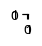

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt

# Load models together
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
%load_ext autoreload
%autoreload 2
    
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.sim_utils import make_dist_matrix
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.metrics import get_metrics, reconstruction_accuracy, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset
import torch
import glob
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180


# Prep TCRBase data using the filtered dataset

In [2]:
filt_df = pd.read_csv('../data/filtered/240418_nettcr_expanded_20binders_17pep_withswaps.csv')
filt_df['seq_id'] = range(len(filt_df))
filt_df.head()

,Unnamed: 0,peptide,A1,A2,A3,B1,B2,B3,allele,partition,binder,origin,original_peptide,raw_index,reference,source_organism,input_type,seq_id
0,0,AVFDRKSDAK,TSDQSYG,QGSYDEQN,ALHSGGYQKVT,MNHEY,SMNVEV,ASSPTRPVEQY,HLA-A*11:01,4,0,peptide_swapped,GILGFVFTL,VDJdb_65943,28636592,InfluenzaA,tcr_pep,0
1,1,KLGGALQAK,TISGTDY,GLTSN,ILTETSYDKVI,SEHNR,FQNEAQ,ASASLGGGLYEQY,HLA-A*03:01,0,0,peptide_swapped,RAKFKQLL,ITRAP_793,37133356,NaN,tcr_pep,1
2,2,ELAGIGILTV,TSESDYY,QEAYKQQN,AYMDNNDMR,SGDLS,YYNGEE,ASSDGQGGYGYT,HLA-A*02:01,3,0,peptide_swapped,KLWAQCVQL,VDJdb_78926,34793243,SARS-CoV-2,tcr_pep,2
3,3,TTDPSFLGRY,ATGYPS,ATKADDK,ALSGNTDKLI,MDHEN,SYDVKM,ASSLAGGIVDEQF,HLA-A*01:01,1,1,VDJdb,TTDPSFLGRY,VDJdb_69875,https://github.com/antigenomics/vdjdb-db/issue...,SARS-CoV-2,tcr_pep,3
4,4,AVFDRKSDAK,TSINN,IRSNERE,ATYSITQGGSEKLV,MRHNA,SNTAGT,ASSPSTYKYNEQF,HLA-A*11:01,1,0,peptide_swapped,KTFPPTEPK,VDJdb_81316,35750048,SARS-CoV-2,tcr_pep,4


In [34]:
%rm -r ../data/TCRBASE/tcrbase_expanded_p0_20binders/
%mkdir -p ../data/TCRBASE/tcrbase_expanded_p0_20binders_swapped/


rm: ../data/TCRBASE/tcrbase_expanded_p0_20binders/: No such file or directory


In [36]:
for p in filt_df.peptide.unique():
    query = filt_df.query('peptide==@p and partition==0')[['seq_id','A1','A2','A3','B1','B2','B3']]
    db = filt_df.query('original_peptide==@p and partition!=0 and binder==1')[['seq_id','A1','A2','A3','B1','B2','B3']]
    query.to_csv(f'../data/TCRBASE/tcrbase_expanded_p0_20binders_swapped/{p}_query_p0.tsv', sep='\t', index=False, header=False)
    db.to_csv(f'../data/TCRBASE/tcrbase_expanded_p0_20binders_swapped/{p}_db_p0.tsv', sep='\t', index=False, header=False)

# Reading results and doing plots etc

## Fct defs and checks

In [4]:
metrics, results = read_tcrbase_results('ELAGIGILTV', filt_df, '../output/TCRBASE/tcrbase_expanded_p0_20binders_swapped/')

ELAGIGILTV 0.932
{'peptide': 'ELAGIGILTV', 'method': 'tcrbase', 'n_pos': 429, 'auc': 0.93198, 'auc_01': 0.80832, 'auc_01_real': 0.63581, 'precision': 0.16758, 'recall': 1.0, 'accuracy': 0.16758, 'AP': 0.80004}


In [51]:
def read_tcrbase_results(peptide, original_df, dir='../output/TCRBASE/tcrbase_expanded_p0_swapped/'):
    cols = ['bs1', 'bs2', 'id_query'] + [f'q_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['bs3', 'bs4', 'id_db'] + [f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['score', 'bs5']
    df = pd.read_csv(f'{dir}{peptide}.txt', comment='#', sep='\s', 
                     header=None, names = cols).drop(columns=[f'bs{i}' for i in range(1,6)])
    results = pd.merge(df.set_index('id_query')[['score', 'id_db']+[f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']]],
                       original_df[['binder', 'original_peptide', 'peptide', 'A1','A2','A3','B1','B2','B3']],
                       left_index=True, right_index=True)
    print(peptide, round(roc_auc_score(results['binder'], results['score']),4))
    tcrbase_metrics = {'peptide':peptide, 
                       'method':'tcrbase',
                       'n_pos':len(original_df.query('original_peptide==@peptide and partition==0'))}
    tcrbase_metrics.update(get_metrics(results['binder'], results['score'], round_digit=5))
    print(tcrbase_metrics)
    return tcrbase_metrics, results
    
def read_tcrvae_results(peptide, original_df, dir):
    csv_file = glob.glob(f'{dir}*{peptide}*.csv')[0]
    df = pd.read_csv(csv_file)
    df['binder']=df['label']
    df['score'] = 1- df['min_dist']
    metrics = {'peptide':peptide, 'method':'_'.join(os.path.basename(csv_file).split('_')[5:]), 
               'n_pos':len(original_df.query('original_peptide==@peptide and partition==0 and binder==0'))}
    metrics.update(get_metrics(df['label'], df['score']))
    return metrics, df

def get_model(folder, map_location='cpu'):
    pt = glob.glob(folder+'/*checkpoint_best*.pt')
    pt = [x for x in pt if 'interval' not in x][0]
    js = glob.glob(folder+'/*checkpoint*.json')[0]
    model = load_model_full(pt, js, map_location='cpu')
    # Extract the vae part if the model comes from a two stage VAE
    if type(model)==TwoStageVAECLF:
        model = model.vae
    model.eval()
    return model

    
def read_tcrbase_results_folds(peptide, original_df, partition, dir='../output/tcrbase_expanded_p0_swapped/'):
    cols = ['xx', 'xy', 'id_query'] + [f'q_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['bs1', 'hit', 'id_db'] + [f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['score', 'bs2']
    df = pd.read_csv(f'{dir}{peptide}_p{partition}.txt', comment='#', sep='\s', header=None, names=cols)

    template_df = original_df.query('partition==@partition and peptide==@peptide')
    template_df = template_df.set_index('fulltcr')[['binder', 'peptide', 'A1','A2','A3','B1','B2','B3']]
    df['fulltcr'] = df['q_A1']+df['q_A2']+df['q_A3']+df['q_B1']+df['q_B2']+df['q_B3']
    results = pd.merge(df.set_index('fulltcr')[['score', 'id_db']+[f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']]],
                       template_df, left_index=True, right_index=True)
    return results

def get_tcrbase_concat(peptide, original_df, dir):
    df = pd.concat([read_tcrbase_results_folds(peptide, original_df, partition, dir) for partition in range(5)])
    df['score_scaled'] = df['score'] / 12
    res = {'peptide':peptide}
    res.update(get_metrics(df['binder'], df['score_scaled'], no_curves=True))
    return res

In [6]:
def do_tcrbase_and_histplots_local(dist_matrix, peptide, f=None, ax=None, unique_filename=None, outdir=None, bins=100):
    query = dist_matrix.query('set=="query"')
    database = dist_matrix.query('set=="database"')
    db_tcrs = database.index.tolist()
    # Scoring query against database & splitting by label
    pos = query[db_tcrs + ['binder']].query('binder==1')
    neg = query[db_tcrs + ['binder']].query('binder==0')
    tcrbase_output = pd.concat([pos, neg])
    pos = pos.drop(columns=['binder']).values
    neg = neg.drop(columns=['binder']).values

    # Getting the AUC for labelling and output DF ;
    pos_out = tcrbase_output.query('binder==1').drop(columns=['binder'])
    neg_out = tcrbase_output.query('binder!=1').drop(columns=['binder'])
    pos_out = pos_out.apply(lambda x: [np.min(x), x.index[int(np.argmin(x))]], axis=1, result_type='expand').rename(
        columns={0: 'min_dist', 1: 'most_similar'})
    neg_out = neg_out.apply(lambda x: [np.min(x), x.index[int(np.argmin(x))]], axis=1, result_type='expand').rename(
        columns={0: 'min_dist', 1: 'most_similar'})
    cat_out = pd.concat([pos_out.assign(label=1), neg_out.assign(label=0)])
    auc = roc_auc_score(cat_out['label'], 1 - cat_out['min_dist'])

    # Plot both the distribution of scores and the "best" score as done above
    #   Plotting distribution of all scores
    pos_flat = pos.flatten()
    neg_flat = neg.flatten()
    cat = np.concatenate([pos_flat, neg_flat])
    labels = np.concatenate([np.array(['pos'] * len(pos_flat) + ['neg'] * len(neg_flat))])
    df_plot_allvsall = pd.DataFrame(data=np.stack([cat, labels]).T, columns=['distance', 'label'])
    df_plot_allvsall['distance'] = df_plot_allvsall['distance'].astype(float)
    pal = sns.color_palette('gnuplot2', 4)
    sns.set_palette([pal[-1], pal[0]])
    sns.set_style('darkgrid')

    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(9, 5))
    sns.histplot(data=df_plot_allvsall, x='distance', hue='label', ax=ax, kde=False,
                 stat='percent', common_norm=False, bins=bins, alpha=0.75)
    # ax.set_xlim([0,1.1])
    ax.set_title(f'TCRBase: All vs All {peptide}: {auc:.4f}', fontsize=14, fontweight='semibold')
    if unique_filename is not None:
        outdir = './' if outdir is None else outdir
        f.savefig(f'{outdir}{peptide}_AvA_TCRBase_distances_histplot_{unique_filename}', dpi=150,
                  bbox_inches='tight')

    #   Plotting "Best" score
    pos_best = pos.min(axis=1).flatten()
    neg_best = neg.min(axis=1).flatten()
    cat_best = np.concatenate([pos_best, neg_best])
    labels_best = np.concatenate([np.array(['pos'] * len(pos_best) + ['neg'] * len(neg_best))])
    df_plot_best = pd.DataFrame(data=np.stack([cat_best, labels_best]).T, columns=['distance', 'label'])
    df_plot_best['distance'] = df_plot_best['distance'].astype(float)
    f2, ax2 = plt.subplots(1, 1, figsize=(9, 5))
    bins = max(int(len(query.query('binder==1')) / 9), 25)

    sns.histplot(data=df_plot_best, x='distance', hue='label', ax=ax2, kde=False,
                 stat='percent', common_norm=False, bins=bins, alpha=0.75)
    # ax.set_xlim([0,1.1])

    ax2.set_title(f'TCRBase: Best score {peptide}, AUC = {auc:.4f}', fontsize=14, fontweight='semibold')
    if unique_filename is not None:
        outdir = './' if outdir is None else outdir
        f2.savefig(f'{outdir}{peptide}_Best_TCRBase_distances_histplot_{unique_filename}', dpi=150, bbox_inches='tight')

    return cat_out

## read some tcrbase results

In [62]:
tcrbase_results = []
for peptide in filt_df.groupby('peptide').agg(c=('B3','count')).sort_values('c',ascending=False).index:
    res, _ = read_tcrbase_results(peptide, filt_df, '../output/TCRBASE/tcrbase_expanded_p0_20binders_swapped/')
    tcrbase_results.append(res)
tcrbase_results = pd.DataFrame(tcrbase_results)

GILGFVFTL 0.803
{'peptide': 'GILGFVFTL', 'method': 'tcrbase', 'n_pos': 929, 'auc': 0.80299, 'auc_01': 0.7191, 'auc_01_real': 0.46628, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.57919}
KLGGALQAK 0.6103
{'peptide': 'KLGGALQAK', 'method': 'tcrbase', 'n_pos': 812, 'auc': 0.6103, 'auc_01': 0.55241, 'auc_01_real': 0.14958, 'precision': 0.16728, 'recall': 1.0, 'accuracy': 0.16728, 'AP': 0.29468}
RAKFKQLL 0.8805
{'peptide': 'RAKFKQLL', 'method': 'tcrbase', 'n_pos': 709, 'auc': 0.88051, 'auc_01': 0.80623, 'auc_01_real': 0.63184, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.76444}
AVFDRKSDAK 0.4855
{'peptide': 'AVFDRKSDAK', 'method': 'tcrbase', 'n_pos': 630, 'auc': 0.48551, 'auc_01': 0.50745, 'auc_01_real': 0.06416, 'precision': 0.16628, 'recall': 1.0, 'accuracy': 0.16628, 'AP': 0.18505}
ELAGIGILTV 0.932
{'peptide': 'ELAGIGILTV', 'method': 'tcrbase', 'n_pos': 429, 'auc': 0.93198, 'auc_01': 0.80832, 'auc_01_real': 0.63581, 'precision': 0.16758, 'recall'

In [69]:
import pandas as pd
import numpy as np

newpeps = filt_df.peptide.unique()

ntr = []
for f in glob.glob('../output/240419_TripletLPO/tcrbase_output/PosOnly/*/'):
    for p in newpeps:
        try:
            ntr.append(read_tcrvae_results(p, filt_df, f)[0])
        except:
            raise ValueError(f'{f} \n\n {p}')

old = []
for f in glob.glob('../output/240419_TripletLPO/tcrbase_output/WithNegs/*/'):
    for p in newpeps:
        old.append(read_tcrvae_results(p, filt_df, f)[0])
        
old = pd.DataFrame(old).assign(method='WithNegs')
ntr = pd.DataFrame(ntr).assign(method='PosOnly')
tcrbase_results['method'] = 'TCRBase'
cat = pd.concat([tcrbase_results, old, ntr])
cat['weight'] = cat['peptide'].apply(lambda x: len(filt_df.query('peptide==@x')) / len(filt_df))

# Define a function to calculate the multiple operations
def calculate_metrics(x):
    normal_avg_auc = x['auc'].mean()
    weighted_avg_auc = np.average(x['auc'], weights=x['weight'])
    normal_avg_auc_01 = x['auc_01'].mean()
    weighted_avg_auc_01 = np.average(x['auc_01'], weights=x['weight'])
    return pd.Series({
        'normal_avg_auc': normal_avg_auc,
        'weighted_avg_auc': weighted_avg_auc,
        'normal_avg_auc_01': normal_avg_auc_01,
        'weighted_avg_auc_01': weighted_avg_auc_01
    })

# Group by the 'group' column and apply the custom calculation function
result = cat.groupby('method').apply(calculate_metrics).reset_index()

result.sort_values('normal_avg_auc',ascending=False)


,method,normal_avg_auc,weighted_avg_auc,normal_avg_auc_01,weighted_avg_auc_01
0,PosOnly,0.744599,0.736943,0.673320,0.664922
1,TCRBase,0.718638,0.729219,0.683492,0.678310
2,WithNegs,0.582312,0.578914,0.554453,0.553272


## for tbcralign, read the index and merge based on full tcr to the filt df and re-create the seq_id

In [7]:

def get_merged_distances_labels(dist_matrix, original_df, index_tcr_df, label_col='peptide', query_subset=None):
    # Assumes a square matrix with no other columns, and that the original_df and index_tcr_df match
    merged = pd.merge(index_tcr_df, original_df[[x for x in original_df.columns if x in['seq_id','peptide','partition','binder','origin','fulltcr']]],
         left_on=['q_index', 'tcr'], right_on=['seq_id','fulltcr'])
    
    assert((merged['seq_id']==merged['q_index']).all() and (merged['tcr']==merged['fulltcr']).all()),'fuck'
    merged = merged.set_index('q_index')[[x for x in merged.columns if x in ['peptide','partition','binder','origin']]]
    merged_dist_matrix = pd.merge(dist_matrix, merged, left_index=True,right_index=True)
    extra_cols = merged_dist_matrix.columns.difference(dist_matrix.columns)
    
    if query_subset is not None:
        query = merged_dist_matrix.query(query_subset)
        merged_dist_matrix = query[list(str(x) for x in query.index)+list(extra_cols)]
    
    return merged_dist_matrix, extra_cols

def get_distances_labels_from_distmatrix(dist_matrix, original_df, index_tcr_df, label_col='peptide', query_subset=None):
    merged_dist_matrix, extra_cols = get_merged_distances_labels(dist_matrix, original_df, index_tcr_df, label_col, query_subset)
    dist_array = merged_dist_matrix.iloc[:,:-len(extra_cols)].values
    features = torch.randn([dist_array.shape[0], 3])
    label_encoder = LabelEncoder()
    labels = merged_dist_matrix[label_col].values
    encoded_labels = label_encoder.fit_transform(labels)
    return merged_dist_matrix, dist_array, features, labels, encoded_labels, label_encoder

In [79]:
tbcr_dm140 = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/OUTPUT_tbcralign_distmatrix_140peps.csv', index_col=0)
tcr_index140 = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/OUTPUT_index_tcrs_140pep.txt')
pos_only_df = pd.read_csv('../data/filtered/240418_nettcr_expanded_20binders_17pep_POSONLY.csv')
pos_only_df['fulltcr'] = pos_only_df['A1'] + pos_only_df['A2'] + pos_only_df['A3'] \
                        + pos_only_df['B1'] + pos_only_df['B2'] + pos_only_df['B3'] 
tcr_index140 = pd.merge(pos_only_df.set_index('fulltcr'), tcr_index140.set_index('tcr'), left_index=True, right_index=True)


In [72]:
display(tcr_index140.head())
display(tbcr_dm140.head())

,q_index,tcr
0,0,ATGYPSATKADDKALSGNTDKLIMDHENSYDVKMASSLAGGIVDEQF
1,1,SSVSVYYLSGSTLVAVSPYNNNDMRSGHNSFNNNVPASRPLAAQETQY
2,2,KTLYGLQKGGEEGADGNFNKFYMNHEYSVGAGIASSQWGQGRETQY
3,3,SSVSVYYLSGSTLVAVSTNTGANSKLTSGHDTYYEEEEASSFRGLN...
4,4,DRGSQSIYSNGDAAPQGAGTALILGHNAYSLEERASSRALLMGNTIY


,0,1,2,3,4,5,6,7,8,9,...,9759,9760,9761,9762,9763,9764,9765,9766,9767,9768
q_index,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.183883,0.178238,0.173911,0.170075,0.187110,0.161335,0.157359,0.193784,0.150145,...,0.142321,0.172775,0.185981,0.163420,0.164203,0.178030,0.204922,0.191003,0.153480,0.144758
1,0.183883,0.000000,0.200009,0.162160,0.203413,0.211574,0.184512,0.192124,0.221551,0.173059,...,0.197166,0.178733,0.209684,0.206792,0.184386,0.225295,0.209033,0.213252,0.181876,0.178095
2,0.178238,0.200009,0.000000,0.214621,0.225911,0.219611,0.209837,0.209927,0.223482,0.193515,...,0.159967,0.217799,0.171142,0.191158,0.193335,0.222728,0.219460,0.217663,0.191211,0.177059
3,0.173911,0.162160,0.214621,0.000000,0.173506,0.185031,0.169649,0.140149,0.201128,0.165969,...,0.187106,0.174421,0.203853,0.180622,0.169914,0.182952,0.221029,0.185741,0.179057,0.176254
4,0.170075,0.203413,0.225911,0.173506,0.000000,0.174970,0.199090,0.152333,0.192469,0.163719,...,0.188831,0.185355,0.184511,0.176676,0.172720,0.193113,0.198398,0.151539,0.183993,0.172008


# TCRBase plots 

In [45]:
def make_3_plots(peptide, original_df, dir_old, dir_new, dir_tcrbase='../output/TCRBASE/tcrbase_expanded_p0_swapped/',
                 name_old=None, name_new=None, name_tcrbase='TCRBase', bins=100):
    _, tcrbase_df = read_tcrbase_results(peptide, original_df, dir_tcrbase)
    _, tcrold_df = read_tcrvae_results(peptide, original_df, dir_old)
    _, tcrnew_df = read_tcrvae_results(peptide, original_df, dir_new)
    
    f,a = plt.subplots(1,3, figsize=(15,4.5))
    ax = a.ravel()
    name_old = 'Old VAE' if name_old is None else name_old
    name_new = 'New MMVAE' if name_new is None else name_new
    tcrbase_auc = roc_auc_score(tcrbase_df['binder'], tcrbase_df['score'])
    tcrold_auc = roc_auc_score(tcrold_df['binder'], tcrold_df['score'])
    tcrnew_auc = roc_auc_score(tcrnew_df['binder'], tcrnew_df['score'])
    tcrbase_df['score'] = tcrbase_df['score'] / 12

    sns.histplot(data = tcrbase_df.rename(columns={'score':'seq_similarity'}), x='seq_similarity', hue='binder', ax=ax[0], kde=False, stat='percent', common_norm=False, bins=bins, alpha=0.75)
    ax[0].set_title(f'{name_tcrbase}\nAUC = {tcrbase_auc:.4f}', fontweight='semibold',fontsize=13)
    sns.histplot(data = tcrold_df.rename(columns={'score':'cos_similarity'}), x='cos_similarity', hue='binder', ax=ax[1], kde=False, stat='percent', common_norm=False, bins=bins, alpha=0.75)
    ax[1].set_title(f'{name_old}\nAUC = {tcrold_auc:.4f}', fontweight='semibold',fontsize=13)
    sns.histplot(data = tcrnew_df.rename(columns={'score':'cos_similarity'}), x='cos_similarity', hue='binder', ax=ax[2], kde=False, stat='percent', common_norm=False, bins=bins, alpha=0.75)
    ax[2].set_title(f'{name_new}\nAUC = {tcrnew_auc:.4f}', fontweight='semibold',fontsize=13)

    # Align plot2 and 3 on xlim
    ax0_xlim = ax[1].get_xlim()
    ax1_xlim = ax[2].get_xlim()
    new_xlim = [min(ax0_xlim[0], ax1_xlim[0]), max(ax0_xlim[1], ax1_xlim[1])]
    # ax[1].set_xlim(new_xlim)
    # ax[2].set_xlim(new_xlim)
    f.suptitle(f'Pep: {peptide}', fontweight='semibold', fontsize=14)
    f.tight_layout()
    return ax

In [44]:
a,b = read_tcrbase_results('GILGFVFTL', df_new, '../output/TCRBASE/tcrbase_expanded_p0_swapped/')
b

GILGFVFTL 0.803
{'peptide': 'GILGFVFTL', 'method': 'tcrbase', 'n_pos': 1095, 'auc': 0.80299, 'auc_01': 0.7191, 'auc_01_real': 0.46628, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.57919}


,score,id_db,db_A1,db_A2,db_A3,db_B1,db_B2,db_B3,binder,original_peptide,peptide,A1,A2,A3,B1,B2,B3
10,10.467048,28856,DRGSQS,IYSNGD,ASVGMDSSYKLI,LNHDA,SQIVND,ASSTRSGTEAF,0,AVFDRKSDAK,GILGFVFTL,DSAIYN,IQSSQRE,AVLRMDSSYKLI,DFQATT,SNEGSKA,SAGSGTRGETQY
39,10.647778,21497,TSENNYY,QEAYKQQN,AFMKGAGGTSYGKLT,SEHNR,FQNEAQ,ASSSLGGHGEAF,0,DATYQRTRALVR,GILGFVFTL,TSESDYY,QEAYKQQN,AYRSAGGGTSYGKLT,SNHLY,FYNNEI,ASSPGTGGNEQY
65,10.962530,6789,NSASQS,VYSSG,GAAGNMLT,MNHEY,SVGEGT,ASGMTGLTSEQY,0,RAKFKQLL,GILGFVFTL,DSASNY,IRSNVGE,AAMETSYDKVI,MNHEY,SVGEGT,ASGMTGLTSEQY
93,10.330496,17474,TTLSN,LVKSGEV,AGHGTASKLT,LNHDA,SQIVND,ASSGRSTDTQY,0,TTDPSFLGRY,GILGFVFTL,NSMFDY,ISSIKDK,AARRWAIGAGKST,MNHEY,SMNVEV,ASSDRAGTDTQY
108,10.294051,1261,SVFSS,VVTGGEV,AGGGSQGNLI,SNHLY,FYNNEI,ASSLSGNRQETQY,0,AVFDRKSDAK,GILGFVFTL,TSGFNG,NVLDGL,AGPPGAGSYQLT,SNHLY,FYNNEI,ASNLAGGRQDTGELF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58440,10.966915,29385,SVFSS,VVTGGEV,AGAGSQGNLI,LGHDT,YNNKEL,ASSRLAGGWNEQF,0,RAKFKQLL,GILGFVFTL,SVFSS,VVTGGEV,AGAGSQGNLI,MGHRA,YSYEKL,ASSLLWAEYNEQF
58453,10.491917,24277,DRGSQS,IYSNGD,AVGGSQGNLI,MNHEY,SVGAGI,ASMVGQGTGELF,0,LLWNGPMAV,GILGFVFTL,DRGSQS,IYSNGD,AVEGGKLI,SQVTM,ANQGSEA,SVEGRGTDTQY
58481,11.557565,37289,TTLSN,LVKSGEV,AGSHGGSQGNLI,LNHDA,SQIVND,ASSQRSTGELF,0,NLVPMVATV,GILGFVFTL,SVFSS,VVTGGEV,AGGHGGSQGNLI,LNHDA,SQIVND,ASSTRSTGELF
58508,10.407818,2123,SSVSVY,YLSGSTLV,AVSVRMDSSYKLI,MGHRA,YSYEKL,ASSQDPGYEQY,0,TPRVTGGGAM,GILGFVFTL,TSINN,IRSNERE,ATEIRMDSSYKLI,SEHNR,FQNEAQ,ASSSRDRGPHGQY


In [16]:
df_17swap = pd.read_csv('../data/filtered/240418_nettcr_expanded_20binders_17pep_withswaps.csv')
df_new = pd.read_csv('../data/multimodal/240326_nettcr_paired_withswaps.csv')

GILGFVFTL 0.803
{'peptide': 'GILGFVFTL', 'method': 'tcrbase', 'n_pos': 1095, 'auc': 0.80299, 'auc_01': 0.7191, 'auc_01_real': 0.46628, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.57919}
GILGFVFTL 0.803
{'peptide': 'GILGFVFTL', 'method': 'tcrbase', 'n_pos': 1095, 'auc': 0.80299, 'auc_01': 0.7191, 'auc_01_real': 0.46628, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.57919}


array([<Axes: title={'center': 'TCRBase\nAUC = 0.8030'}, xlabel='seq_similarity', ylabel='Percent'>,
       <Axes: title={'center': 'CDR3 1-Stage ; No Triplet\nAUC = 0.7476'}, xlabel='cos_similarity', ylabel='Percent'>,
       <Axes: title={'center': 'AllCDRs 1-Stage Small model ; No Triplet\nAUC = 0.7894'}, xlabel='cos_similarity', ylabel='Percent'>],
      dtype=object)

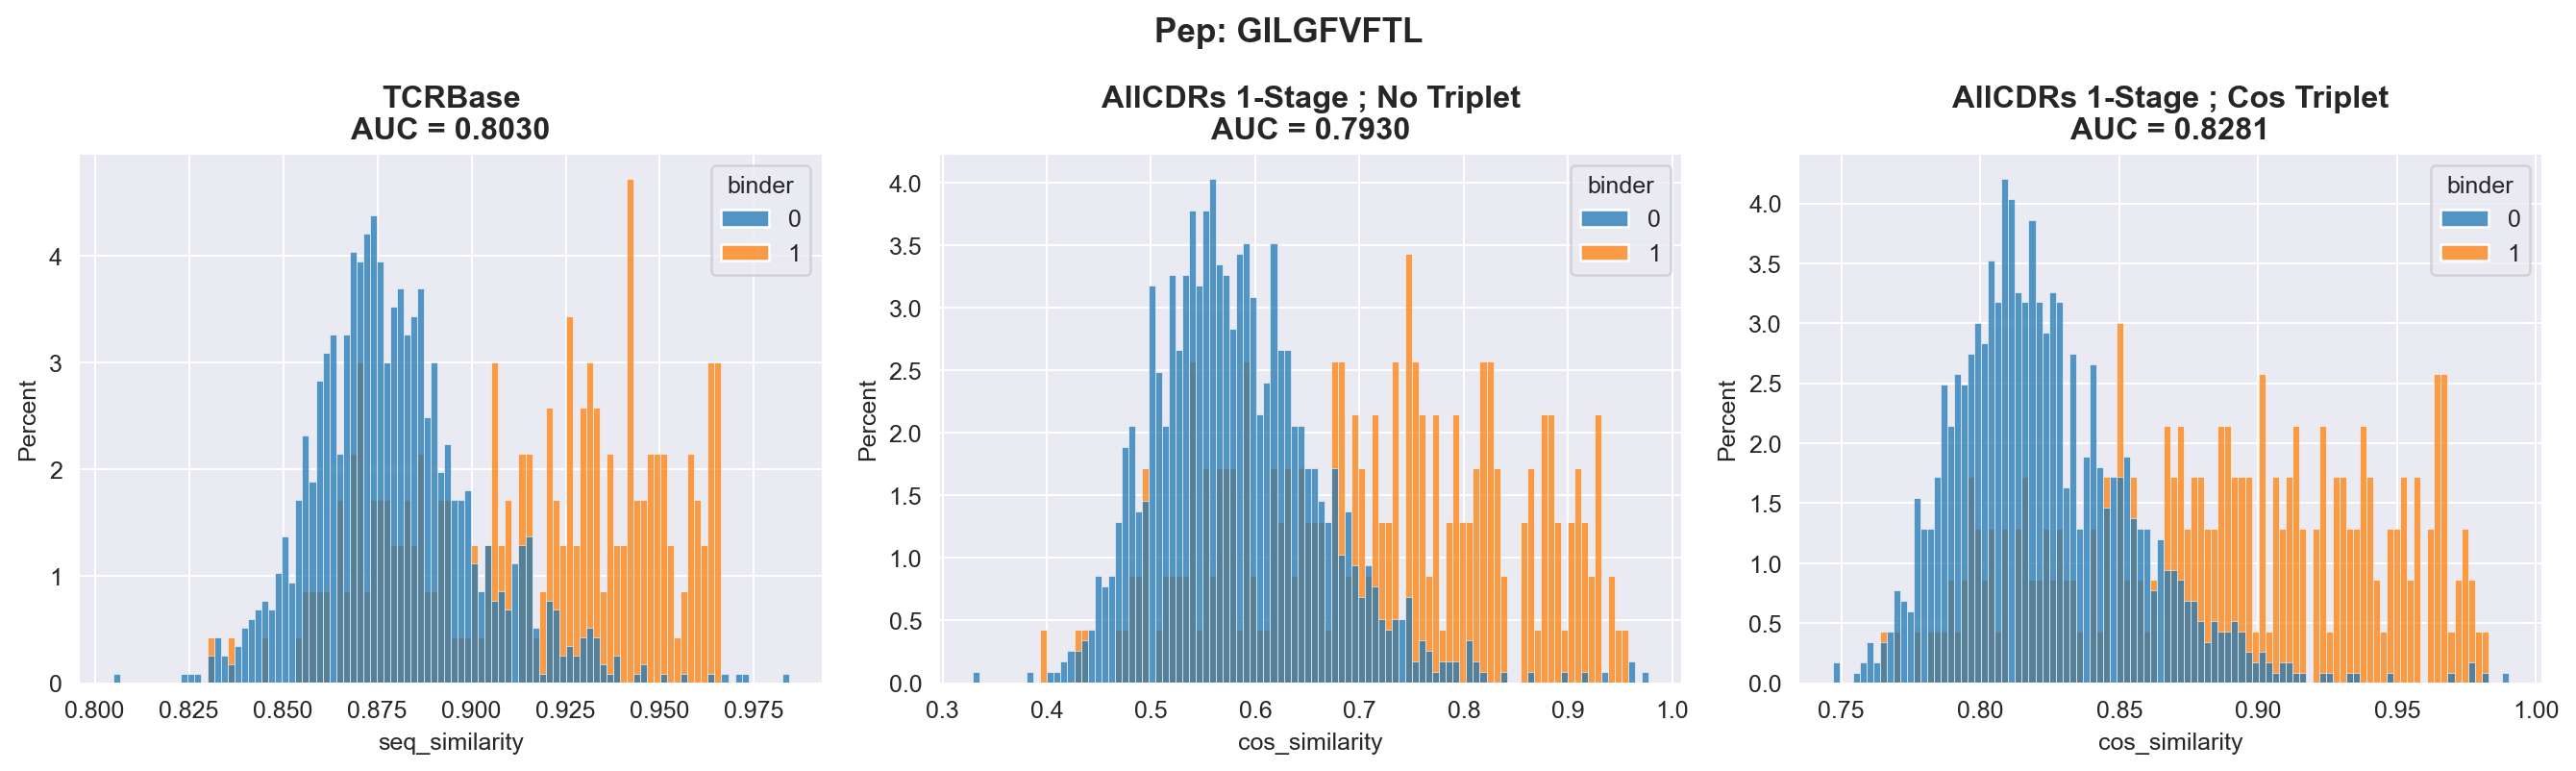

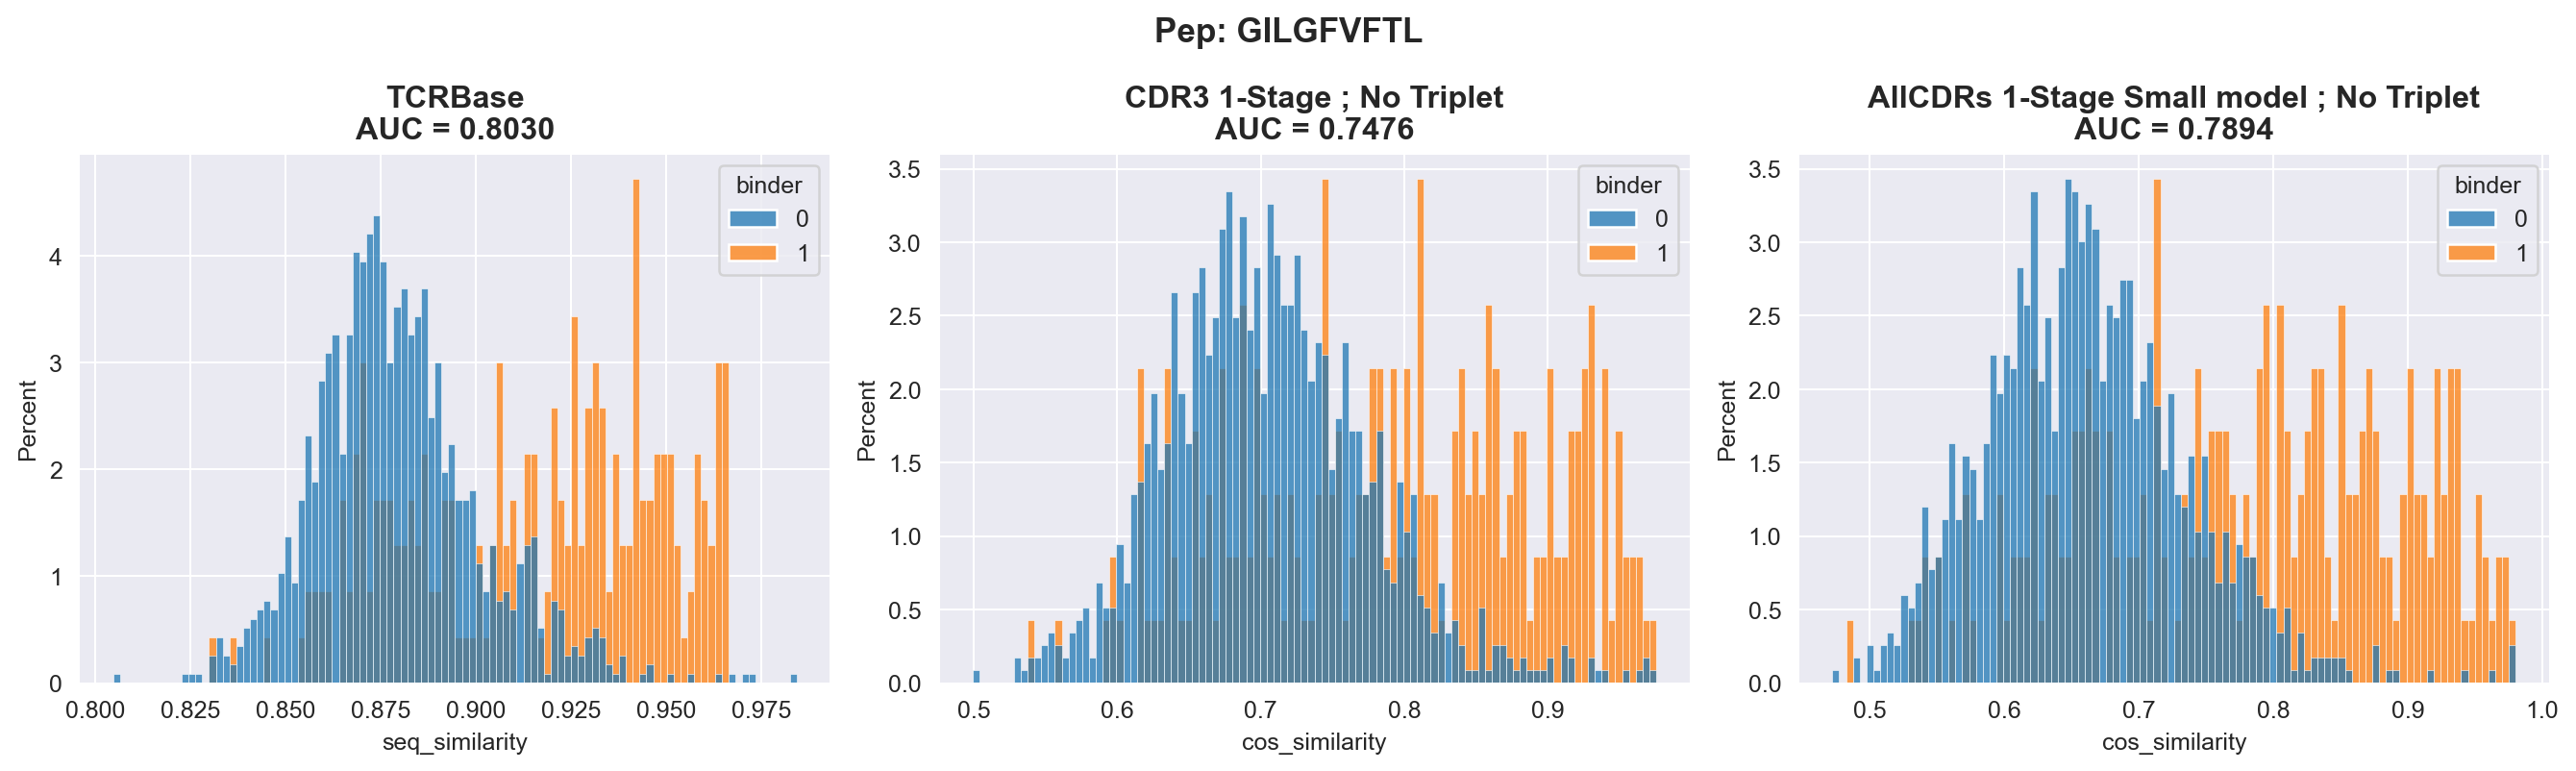

In [57]:
make_3_plots('GILGFVFTL', df_new, '../output/240425_tcrbase_ntmlgp/fulltcr_1stage_large_notriplet//',
             '../output/240425_tcrbase_ntmlgp/fulltcr_1stage_large_costriplet//', 
             dir_tcrbase='../output/TCRBASE/tcrbase_expanded_p0_swapped/', 
             name_old='AllCDRs 1-Stage ; No Triplet',  
             name_new='AllCDRs 1-Stage ; Cos Triplet')
make_3_plots('GILGFVFTL', df_new, '../output/240425_tcrbase_ntmlgp/cdr3_1stage_small_notriplet/',
             '../output/240425_tcrbase_ntmlgp/fulltcr_1stage_small_notriplet/', 
             dir_tcrbase='../output/TCRBASE/tcrbase_expanded_p0_swapped/', 
             name_old='CDR3 1-Stage ; No Triplet', 
             name_new='AllCDRs 1-Stage Small model ; No Triplet')

KLGGALQAK 0.6103
{'peptide': 'KLGGALQAK', 'method': 'tcrbase', 'n_pos': 1130, 'auc': 0.6103, 'auc_01': 0.55241, 'auc_01_real': 0.14958, 'precision': 0.16728, 'recall': 1.0, 'accuracy': 0.16728, 'AP': 0.29468}
KLGGALQAK 0.6103
{'peptide': 'KLGGALQAK', 'method': 'tcrbase', 'n_pos': 1130, 'auc': 0.6103, 'auc_01': 0.55241, 'auc_01_real': 0.14958, 'precision': 0.16728, 'recall': 1.0, 'accuracy': 0.16728, 'AP': 0.29468}


array([<Axes: title={'center': 'TCRBase\nAUC = 0.6103'}, xlabel='seq_similarity', ylabel='Percent'>,
       <Axes: title={'center': 'CDR3 1-Stage ; No Triplet\nAUC = 0.5965'}, xlabel='cos_similarity', ylabel='Percent'>,
       <Axes: title={'center': 'AllCDRs 1-Stage Small model ; No Triplet\nAUC = 0.5826'}, xlabel='cos_similarity', ylabel='Percent'>],
      dtype=object)

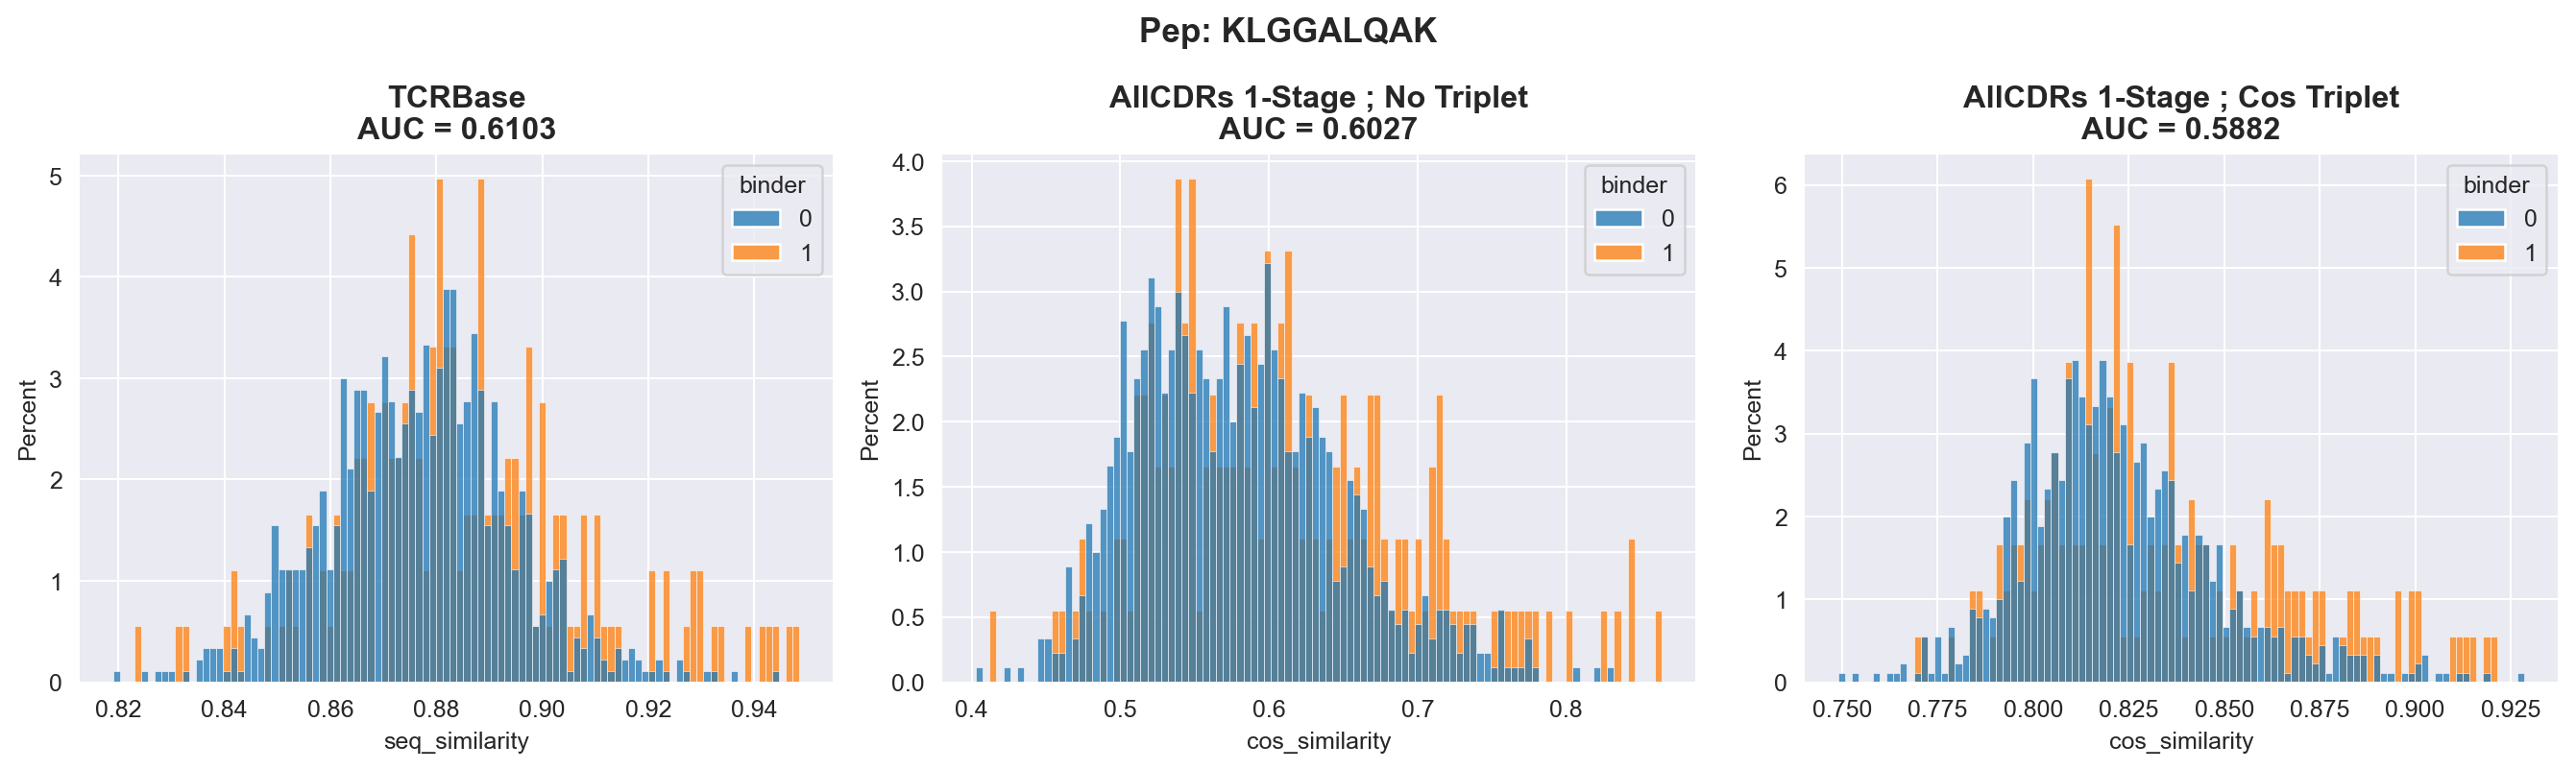

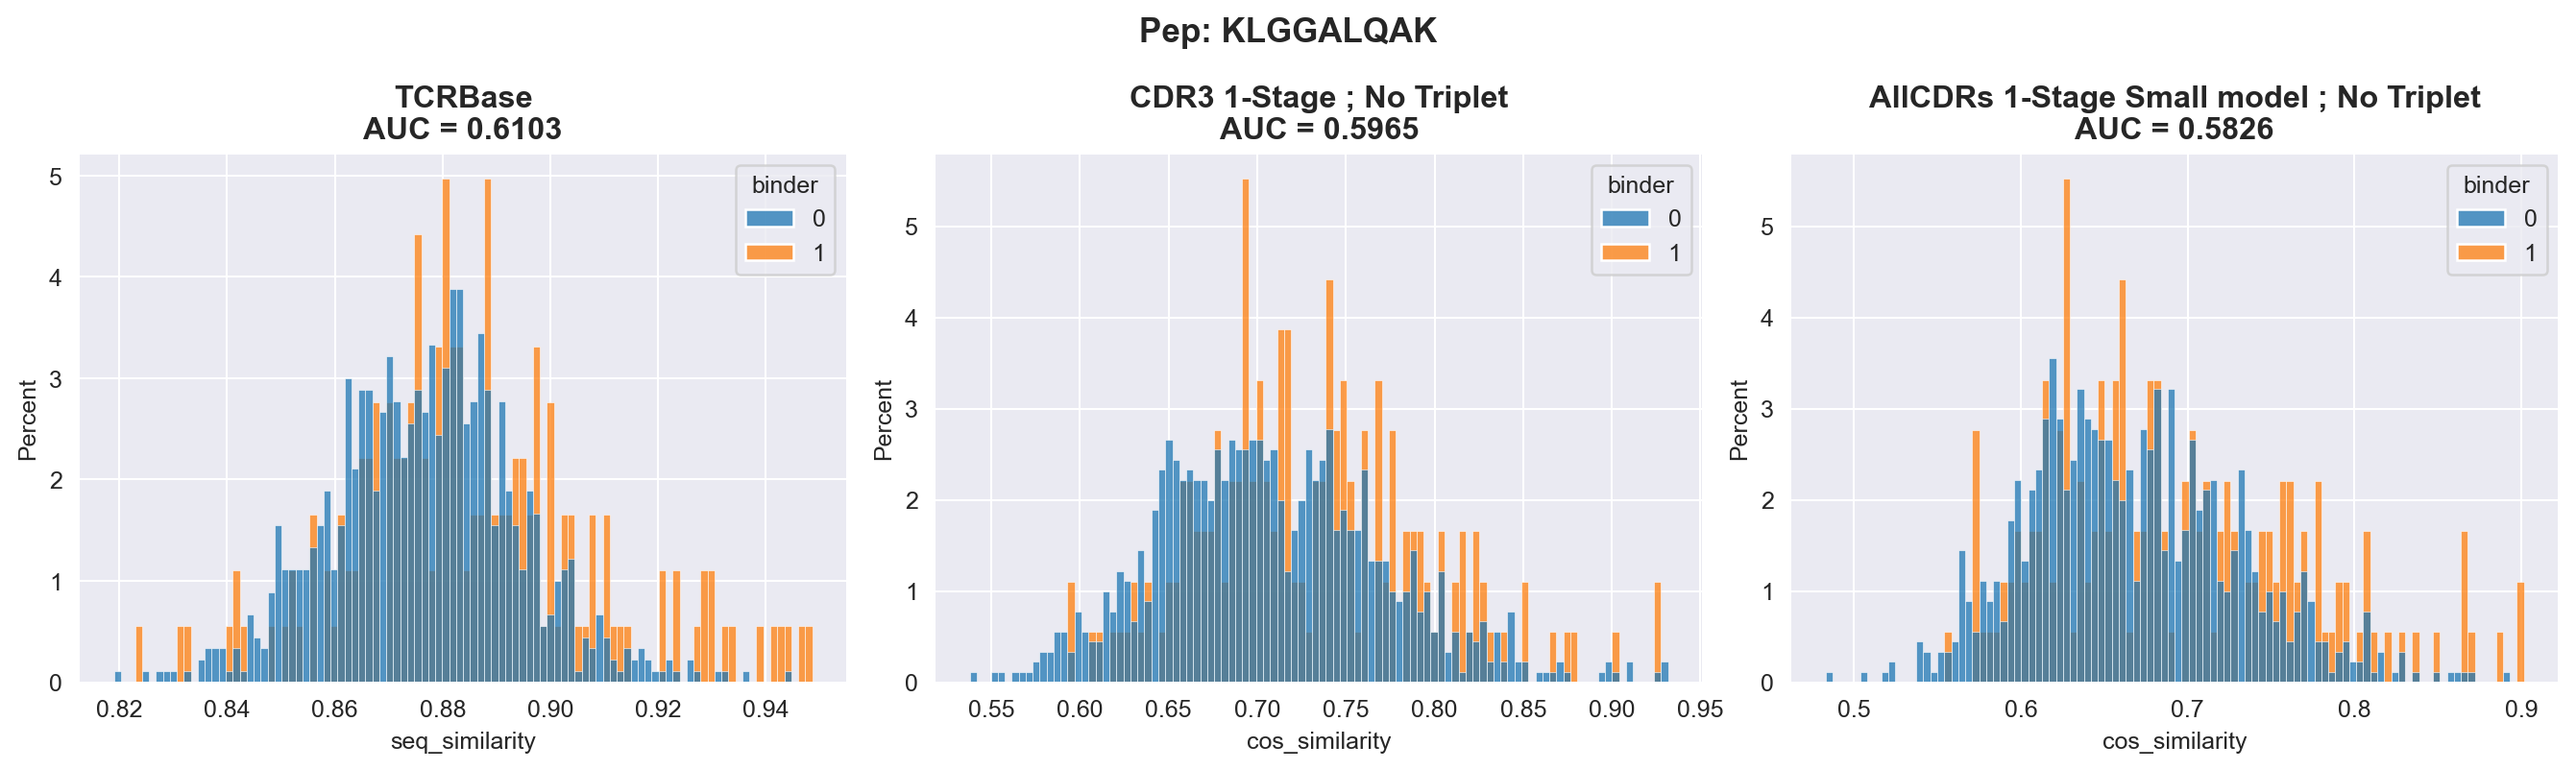

In [56]:
make_3_plots('KLGGALQAK', df_new, '../output/240425_tcrbase_ntmlgp/fulltcr_1stage_large_notriplet//',
             '../output/240425_tcrbase_ntmlgp/fulltcr_1stage_large_costriplet//', 
             dir_tcrbase='../output/TCRBASE/tcrbase_expanded_p0_swapped/', 
             name_old='AllCDRs 1-Stage ; No Triplet',  
             name_new='AllCDRs 1-Stage ; Cos Triplet')
make_3_plots('KLGGALQAK', df_new, '../output/240425_tcrbase_ntmlgp/cdr3_1stage_small_notriplet/',
             '../output/240425_tcrbase_ntmlgp/fulltcr_1stage_small_notriplet/', 
             dir_tcrbase='../output/TCRBASE/tcrbase_expanded_p0_swapped/', 
             name_old='CDR3 1-Stage ; No Triplet', 
             name_new='AllCDRs 1-Stage Small model ; No Triplet')

RAKFKQLL 0.8805
{'peptide': 'RAKFKQLL', 'method': 'tcrbase', 'n_pos': 945, 'auc': 0.88051, 'auc_01': 0.80623, 'auc_01_real': 0.63184, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.76444}
RAKFKQLL 0.8805
{'peptide': 'RAKFKQLL', 'method': 'tcrbase', 'n_pos': 945, 'auc': 0.88051, 'auc_01': 0.80623, 'auc_01_real': 0.63184, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.76444}


array([<Axes: title={'center': 'TCRBase\nAUC = 0.8805'}, xlabel='seq_similarity', ylabel='Percent'>,
       <Axes: title={'center': 'CDR3 1-Stage ; No Triplet\nAUC = 0.8204'}, xlabel='cos_similarity', ylabel='Percent'>,
       <Axes: title={'center': 'AllCDRs 1-Stage Small model ; No Triplet\nAUC = 0.8353'}, xlabel='cos_similarity', ylabel='Percent'>],
      dtype=object)

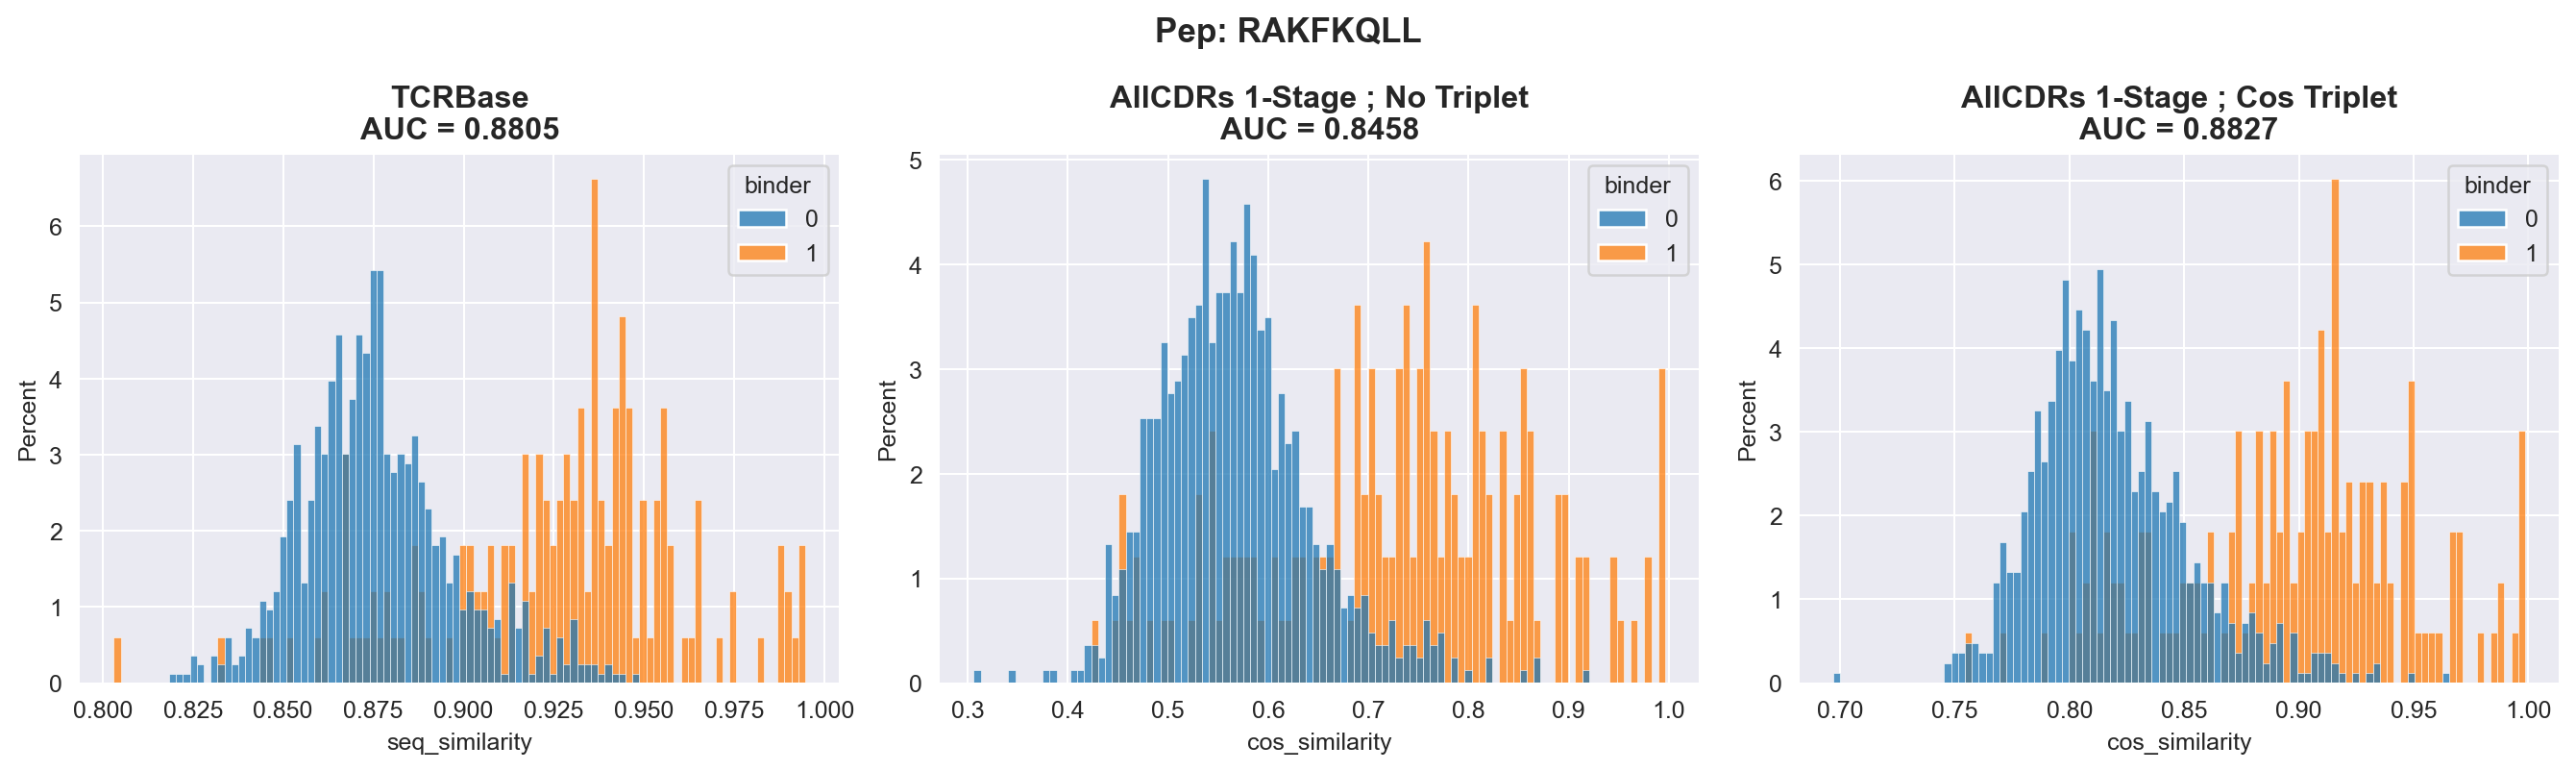

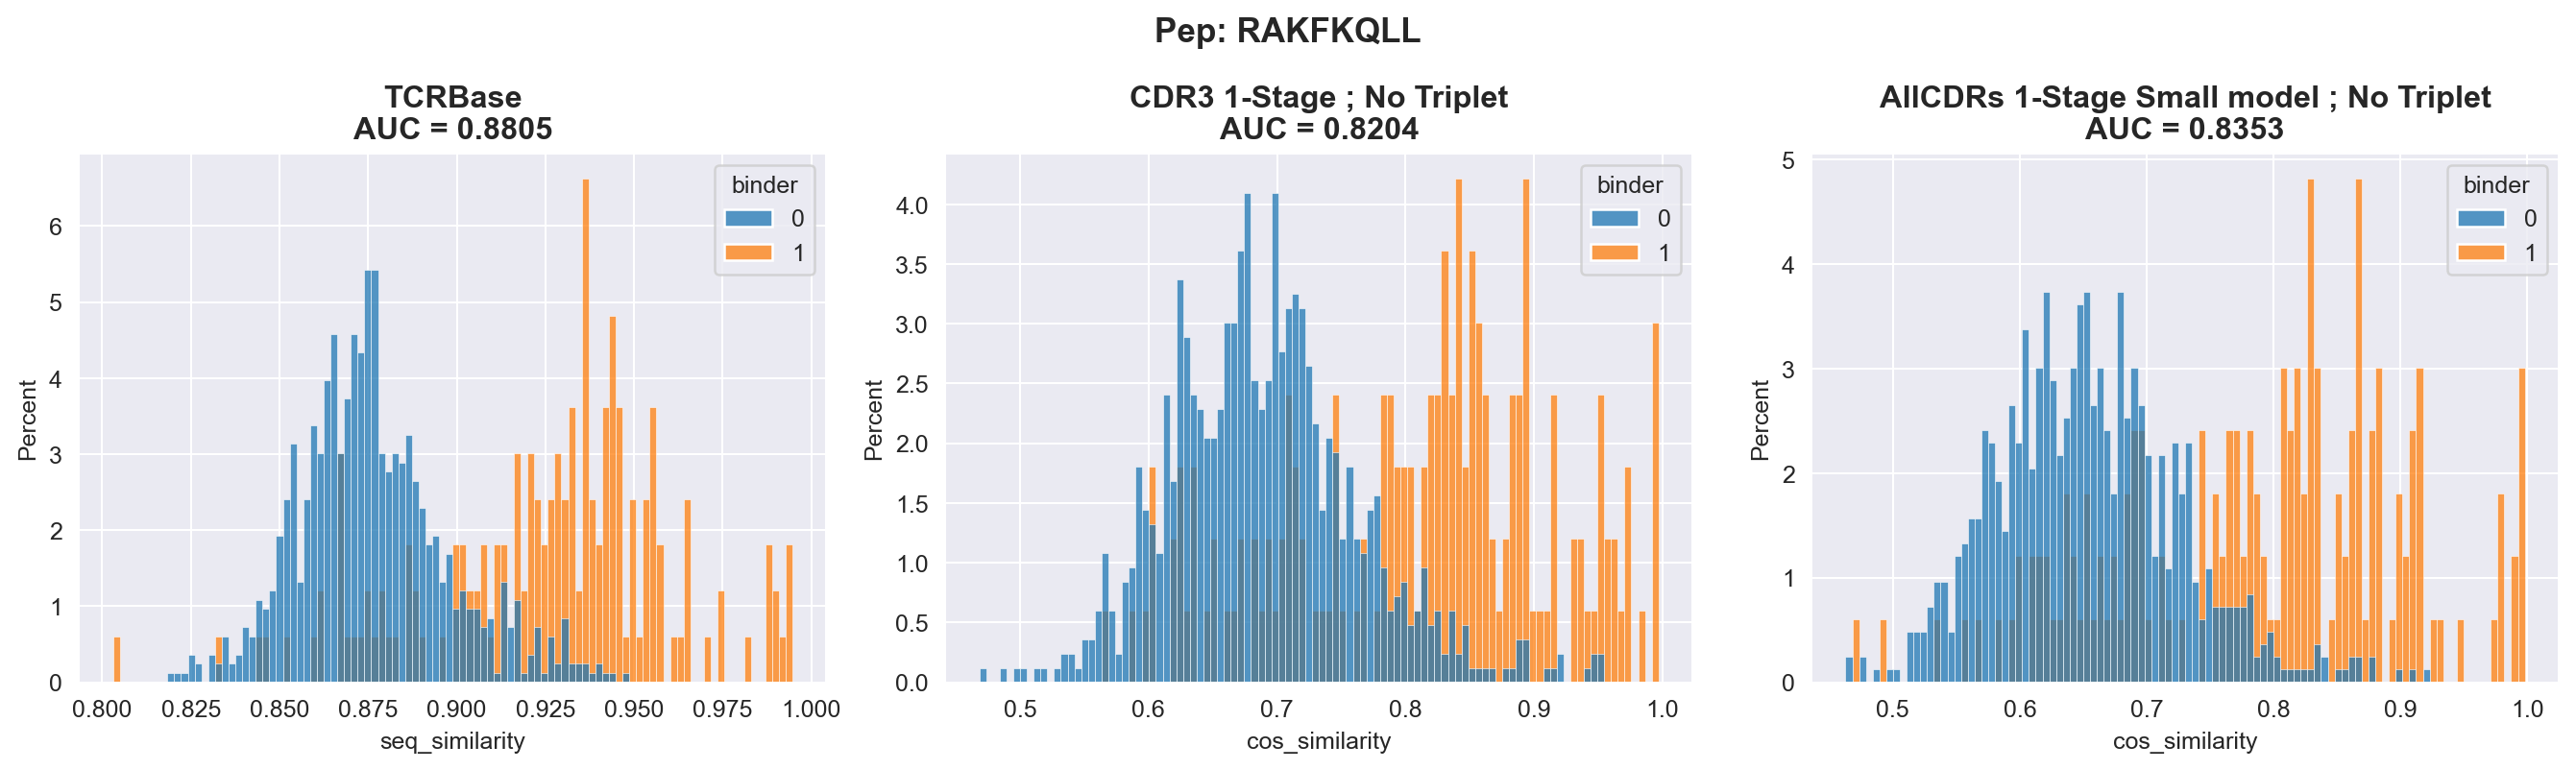

In [55]:
make_3_plots('RAKFKQLL', df_new, '../output/240425_tcrbase_ntmlgp/fulltcr_1stage_large_notriplet//',
             '../output/240425_tcrbase_ntmlgp/fulltcr_1stage_large_costriplet//', 
             dir_tcrbase='../output/TCRBASE/tcrbase_expanded_p0_swapped/', 
             name_old='AllCDRs 1-Stage ; No Triplet',  
             name_new='AllCDRs 1-Stage ; Cos Triplet')
make_3_plots('RAKFKQLL', df_new, '../output/240425_tcrbase_ntmlgp/cdr3_1stage_small_notriplet/',
             '../output/240425_tcrbase_ntmlgp/fulltcr_1stage_small_notriplet/', 
             dir_tcrbase='../output/TCRBASE/tcrbase_expanded_p0_swapped/', 
             name_old='CDR3 1-Stage ; No Triplet', 
             name_new='AllCDRs 1-Stage Small model ; No Triplet')

In [50]:
df_new.groupby('peptide').agg(count=('B3','count')).sort_values('count',ascending=False).head(25)
KLGGALQAK
RAKFKQLL
AVFDRKSDAK

,count
peptide,
GILGFVFTL,6990
KLGGALQAK,5406
RAKFKQLL,4980
AVFDRKSDAK,4302
ELAGIGILTV,2742
SPRWYFYYL,2694
YLQPRTFLL,2394
TTDPSFLGRY,2322
LLWNGPMAV,2226


In [53]:
read_tcrbase_results('KLGGALQAK', df_new)

KLGGALQAK 0.6103
{'peptide': 'KLGGALQAK', 'method': 'tcrbase', 'n_pos': 1130, 'auc': 0.6103, 'auc_01': 0.55241, 'auc_01_real': 0.14958, 'precision': 0.16728, 'recall': 1.0, 'accuracy': 0.16728, 'AP': 0.29468}


({'peptide': 'KLGGALQAK',
  'method': 'tcrbase',
  'n_pos': 1130,
  'auc': 0.6103,
  'auc_01': 0.55241,
  'auc_01_real': 0.14958,
  'precision': 0.16728,
  'recall': 1.0,
  'accuracy': 0.16728,
  'AP': 0.29468},
            score  id_db    db_A1     db_A2            db_A3   db_B1    db_B2  \
 1      10.488678    748  TISGTDY     GLTSN      ILTDILTDKLI   LGHNA   YNFKEQ   
 57     10.556997  17917    TSINN   IRSNERE      ATEGLERSTLT   LNHDA   SQIVND   
 72     10.297656   3742   SSVPPY  YTSAATLV    AVSETYSSASKII   LGHNA   YSLEER   
 119    10.351130     55  NIATNDY     GYKTK   LVGDMRGGSNYQLI   LGHNA   YSLEER   
 188    10.641288   6709   NSASQS     VYSSG         VVAGNQFY   SGHRS   YFSETQ   
 ...          ...    ...      ...       ...              ...     ...      ...   
 58321  10.409118  43812   DSASNY   IRSNVGE     AAKLSDSSYKLI  DFQATT  SNEGSKA   
 58381  10.521156   8149   DRGSQS    IYSNGD      AGGNFGNEKLT   SGHRS   YFSETQ   
 58480  10.630177   4625   DRGSQS    IYSNGD  AAGFMNYGGSQGNL

ELAGIGILTV 0.932
{'peptide': 'ELAGIGILTV', 'method': 'tcrbase', 'n_pos': 502, 'auc': 0.93198, 'auc_01': 0.80832, 'auc_01_real': 0.63581, 'precision': 0.16758, 'recall': 1.0, 'accuracy': 0.16758, 'AP': 0.80004}
ELAGIGILTV 0.932
{'peptide': 'ELAGIGILTV', 'method': 'tcrbase', 'n_pos': 502, 'auc': 0.93198, 'auc_01': 0.80832, 'auc_01_real': 0.63581, 'precision': 0.16758, 'recall': 1.0, 'accuracy': 0.16758, 'AP': 0.80004}


array([<Axes: title={'center': 'TCRBase\nAUC = 0.9320'}, xlabel='seq_similarity', ylabel='Percent'>,
       <Axes: title={'center': 'CDR3 1-Stage ; No Triplet\nAUC = 0.7681'}, xlabel='cos_similarity', ylabel='Percent'>,
       <Axes: title={'center': 'AllCDRs 1-Stage Small model ; No Triplet\nAUC = 0.8402'}, xlabel='cos_similarity', ylabel='Percent'>],
      dtype=object)

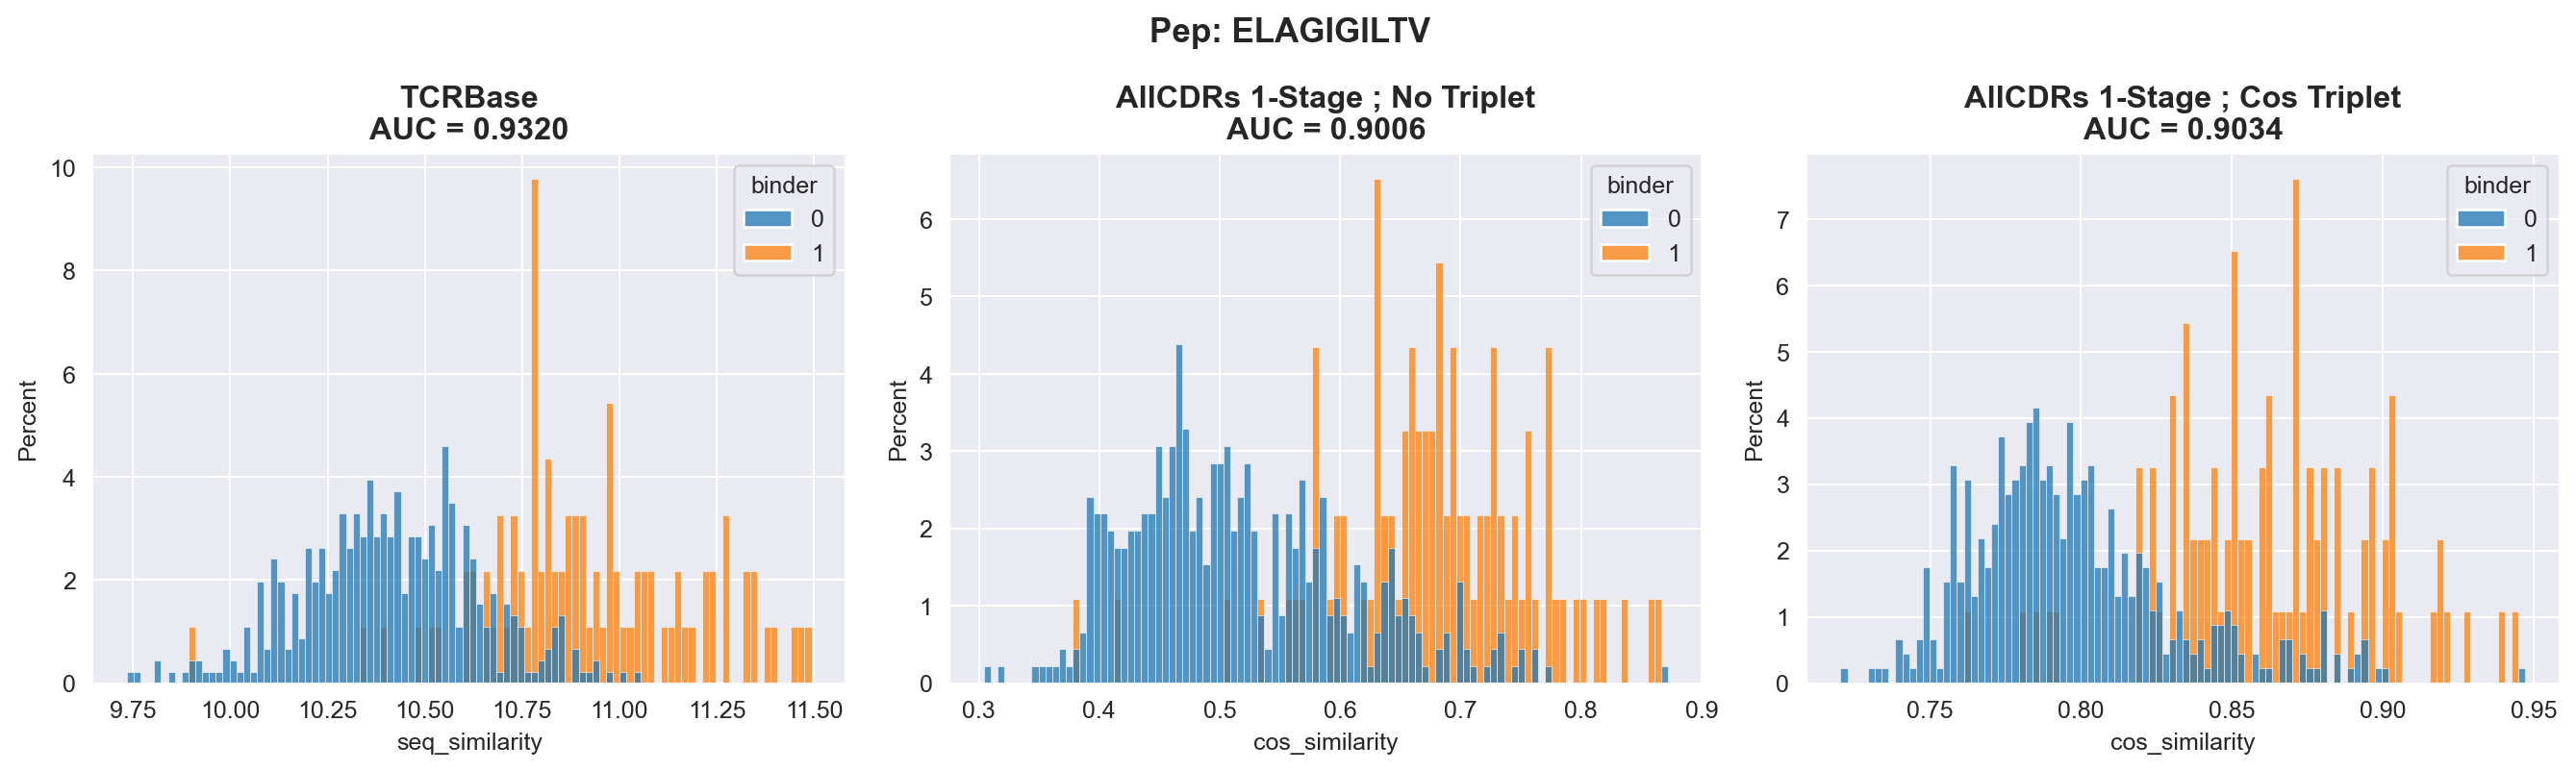

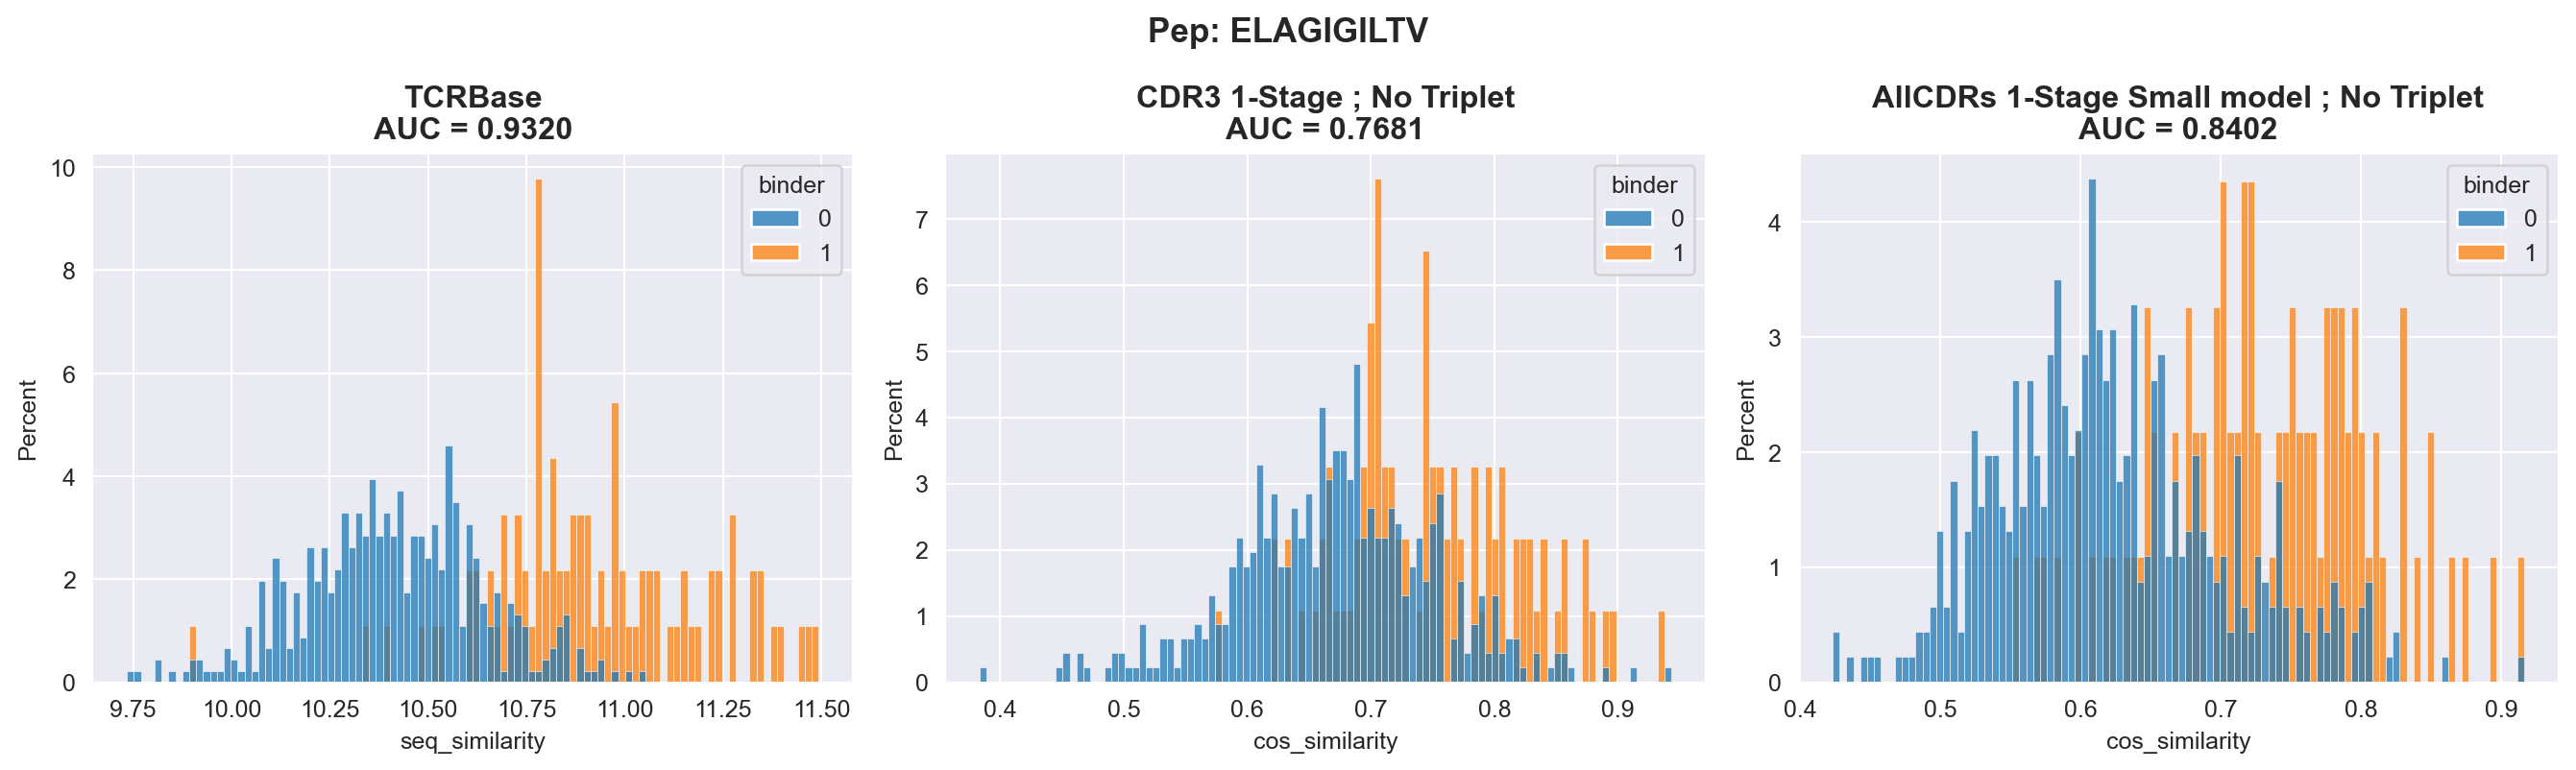

In [39]:
make_3_plots('ELAGIGILTV', df_new, '../output/240425_tcrbase_ntmlgp/fulltcr_1stage_large_notriplet//',
             '../output/240425_tcrbase_ntmlgp/fulltcr_1stage_large_costriplet//', 
             dir_tcrbase='../output/TCRBASE/tcrbase_expanded_p0_swapped/', 
             name_old='AllCDRs 1-Stage ; No Triplet',  
             name_new='AllCDRs 1-Stage ; Cos Triplet')
make_3_plots('ELAGIGILTV', df_new, '../output/240425_tcrbase_ntmlgp/cdr3_1stage_small_notriplet/',
             '../output/240425_tcrbase_ntmlgp/fulltcr_1stage_small_notriplet/', 
             dir_tcrbase='../output/TCRBASE/tcrbase_expanded_p0_swapped/', 
             name_old='CDR3 1-Stage ; No Triplet', 
             name_new='AllCDRs 1-Stage Small model ; No Triplet')